# This notebook serves to demonstrate data analysis pipeline for vortex line experiment. Screenshot of raw data overlaid with particle and line tracking below:

![Expental data](muvi_screenshot_00000000.png)

In [1]:
import muvi #https://github.com/klecknerlab/muvi
from vtianalysis import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
# import sys
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit


#The windowed_polynomial_resample function resamples irregularly spaced data and computes spatial derivatives using a polynomial fit within a specified cutoff radius, with options for different weighting functions and parallel processing. It’s ideal for interpolating data and calculating derivatives in noisy, non-uniform datasets.
from muvi.geometry.resample import windowed_polynomial_resample

#Specifies the correct path to the dataset being analyzed
dir_path = r"E:\2024_09_03\1400_downstream_offset_down"

#This initialization creates a set of directories associated with the analysis pipeline to keep everything organized, eg. vortex_path, tracks_path, vol_path, figures_path
muvi = VTIAnalysis(dir_path)

In [ ]:
#This cell is used to specify imaging parameters, used to filter out data and adjust velocities in later analysis
muvi.get_muvi_info(y_min_start=-25.5,z_min_start=-25.5,y_max_start=24.5,z_max_start=24.5,frame_type='downstream',
                   y_min_finish=-24,z_min_finish=-25.7,y_max_finish=26,z_max_finish=24.3,cart_velocity=20, x_start=(126-144.6))

In [ ]:
#Vortex lines are tracked using Fast Marching Method, restricted to rectangular prism around where vortices are located.
#This saves the dimensions of these prisms to restrict Fast Marching Method, ensuring proper tracking of vortex lines
muvi.get_muvi_vortex_info(int_min_x1=-150, int_min_y1=10.4, int_min_z1=-12.4, int_max_x1=150, int_max_y1=16, int_max_z1=3.5,
int_min_x2=-150,  int_min_y2=-19.2, int_min_z2=-14.4, int_max_x2=150, int_max_y2=-5, int_max_z2=4)

In [ ]:
#Method used to track particles in many frames. Use "batch" to manage memory resources
muvi.track_particles(start_frame=0, end_frame=None, batch=16, diameter=5, separation=3, threshold=1E-4)

In [ ]:
#Method using Fast Marching Method to track vortex lines, using parameters specified earlier
muvi.track_vortex_core()

In [ ]:
#This method filters out unneeded points trackpy locates. Colloids stuck to the walls, and brighter points along vortex lines are filtered using this step
#"radius" filters tracked particles within the specified radius around tracked vortex lines
muvi.filter_tracked_particles(radius=1)

In [ ]:
#Method used to link located particles from frame to frame together
muvi.link(search_range=(3,3,11), memory=3, adaptive_stop=(1,1,3))

In [ ]:
#This method uses linked particles from trackpy to compute velocity of tracked particles.
#Uses a Modified Savitzky-Golay filter to create locations and velocities {Ri,Vi} in each frame
muvi.traj()

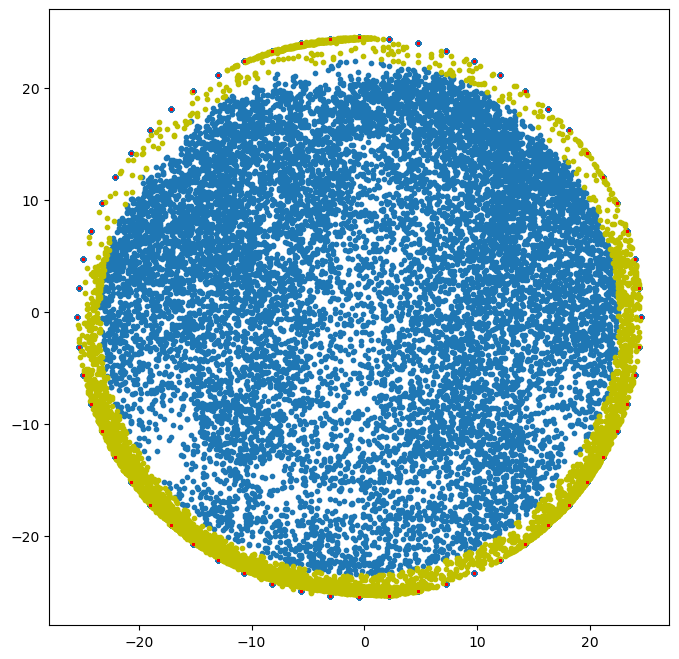

In [5]:
#Visualize trajectory locations {Ri} for a given frame
muvi.scatter_traj(frame=35)

In [ ]:
#Resample trajectories {Ri,Vi} onto a regular grid. Grid goes from -Lx to Lx, -Ly to Ly, and -Lz to Lz at a resolution of (rx,ry,rz)
#Resampler is a Windowed Polynomial Resampler using a weighted Hann window
#"error_threshold" excludes points that are above threshold to resampling scheme
#"exclusion_mm" excludes points within this amount from the inside of the walls, where tracking becomes less reliable
#"resample_type" changes the field being resampled. Later analysis separates velocity field into 3 components -- measured, vortex, and background
muvi.resample_muvi(start_frame=0, end_frame=None, Lx=150, Ly=29, Lz=29, resolution=(2,2,2),error_threshold=2, exclusion_mm=2, resample_type ='measured')

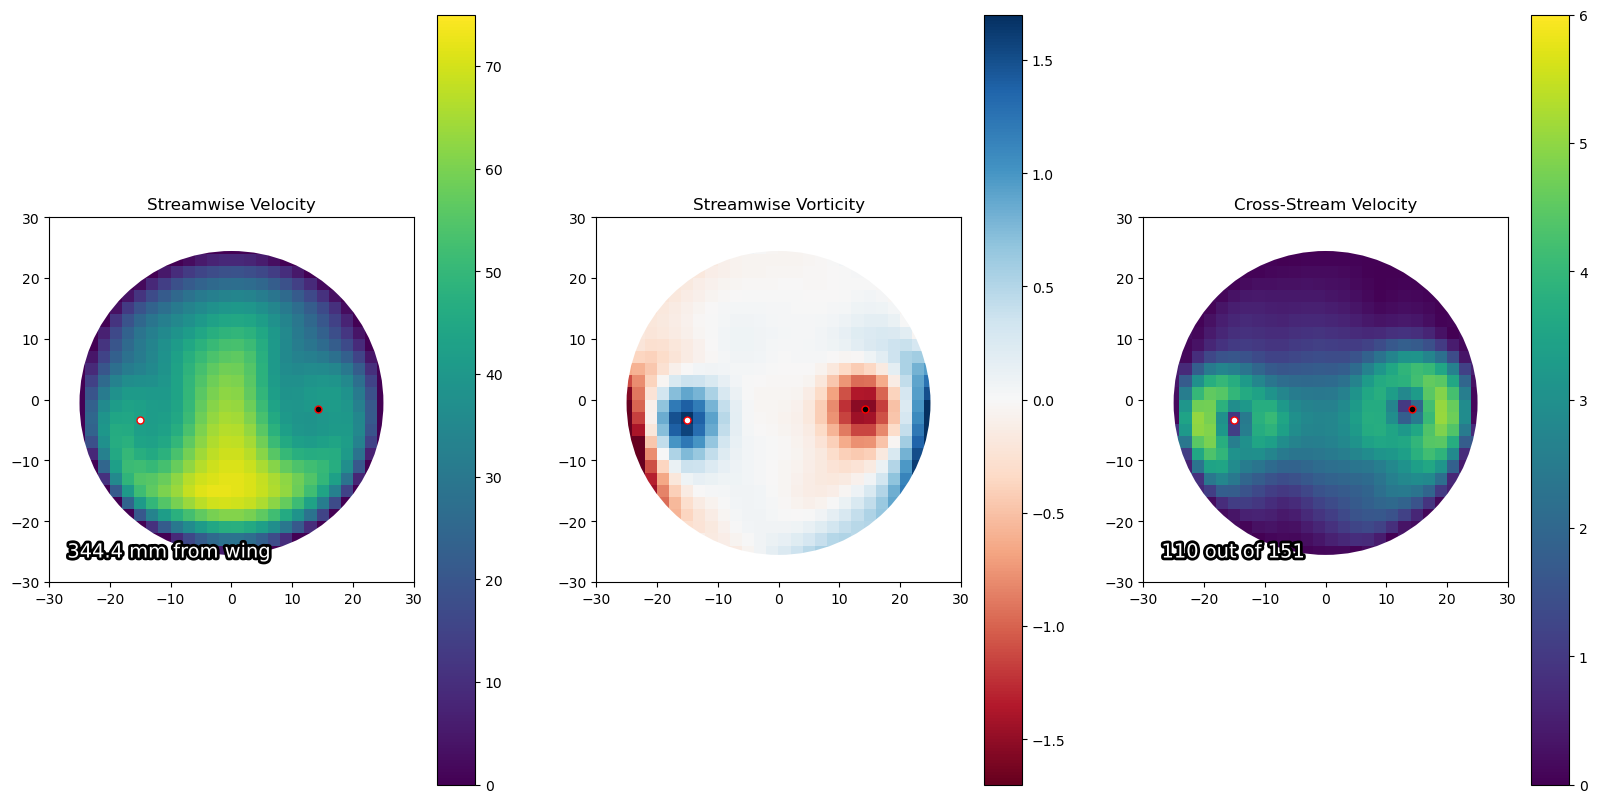

In [4]:
#Visualize cross-section of streamwise velocity, streamwise vorticity, and cross-stream vorticity
#Also displays location of tracked dye lines at any given cross-section
#Options are to adjust colormaps for different datasets and show computation window of vorticity
muvi.view_volume_slice(frame=500, x_plane=110,streamwise_max=75,vorticity_range=1.7,crosswise_max=6.0,show_d=False,com_rad=20)

In [ ]:
#Computes vortex core info based off resampled values. Used to track circulation
muvi.vortex_core_info()

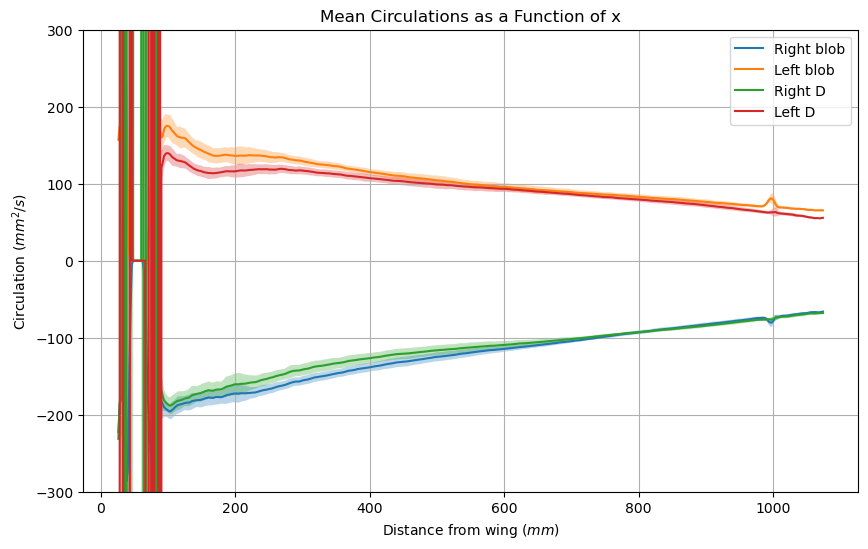

In [12]:
#Plot circulation as a function of distance from wing, shaded by 1stdev margin
#Measured two different ways, one computing the area integral within a D-shaped contour, another using a threshold to find the "blob" and integrate over that
stats_data = pd.read_pickle(os.path.join(muvi.measure_path, 'vortex_measurements_avg.pkl'))
right_mean = stats_data['right_circ_mean']
right_std = stats_data['right_circ_std']
left_mean = stats_data['left_circ_mean']
left_std = stats_data['left_circ_std']
right_mean2 = stats_data['right_circ_d_mean']
right_std2 = stats_data['right_circ_d_std']
left_mean2 = stats_data['left_circ_d_mean']
left_std2 = stats_data['left_circ_d_std']

plt.figure(figsize=(10, 6))
plt.plot(stats_data['x'], right_mean, label='Right blob')
plt.fill_between(stats_data['x'], right_mean-right_std, right_mean+right_std, alpha=0.3)
plt.plot(stats_data['x'], left_mean, label='Left blob')
plt.fill_between(stats_data['x'], left_mean-left_std, left_mean+left_std, alpha=0.3)
plt.plot(stats_data['x'], right_mean2, label='Right D')
plt.fill_between(stats_data['x'], right_mean2-right_std2, right_mean2+right_std2, alpha=0.3)
plt.plot(stats_data['x'], left_mean2, label='Left D')
plt.fill_between(stats_data['x'], left_mean2-left_std2, left_mean2+left_std2, alpha=0.3)
plt.xlabel('Distance from wing ($mm$)') 
plt.ylabel('Circulation ($mm^2/s$)')
plt.title('Mean Circulations as a Function of x')
plt.legend()
plt.ylim(-300,300)
plt.grid(True)
plt.show()

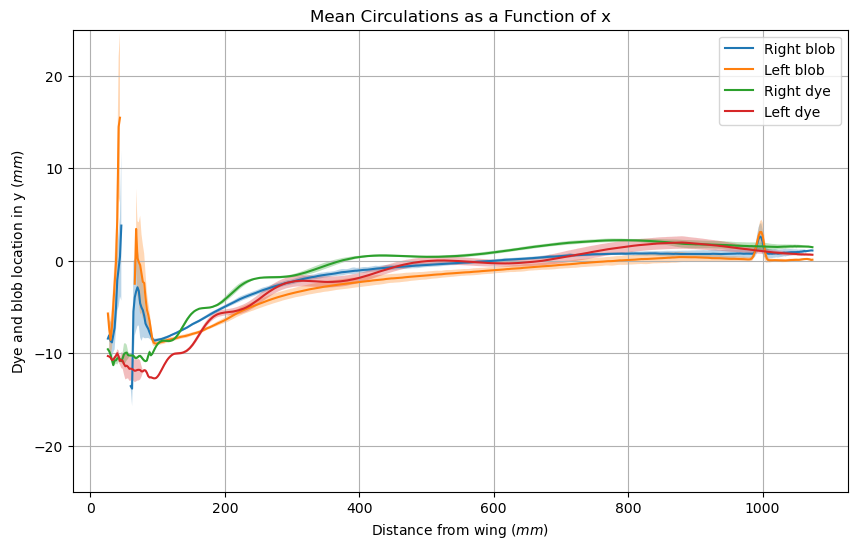

In [15]:
#Tracks center-of-mass of blob location compared to dye line as a function of distance from wing
#Also shaded by 1stdev in uncertainty of location
stats_data = pd.read_pickle(os.path.join(muvi.measure_path, 'vortex_measurements_avg.pkl'))
x_values = stats_data['x']
right_mean = stats_data['right_circ_z_mean']
right_std = stats_data['right_circ_z_std']
left_mean = stats_data['left_circ_z_mean']
left_std = stats_data['left_circ_z_std']
right_mean2 = stats_data['right_dye_z_mean']
right_std2 = stats_data['right_dye_z_std']
left_mean2 = stats_data['left_dye_z_mean']
left_std2 = stats_data['left_dye_z_std']
plt.figure(figsize=(10, 6))
plt.plot(x_values, right_mean, label='Right blob')
plt.fill_between(x_values, right_mean-right_std, right_mean+right_std, alpha=0.3)
plt.plot(x_values, left_mean, label='Left blob')
plt.fill_between(x_values, left_mean-left_std, left_mean+left_std, alpha=0.3)
plt.plot(x_values2, right_mean2, label='Right dye')
plt.fill_between(x_values2, right_mean2-right_std2, right_mean2+right_std2, alpha=0.3)
plt.plot(x_values2, left_mean2, label='Left dye')
plt.fill_between(x_values2, left_mean2-left_std2, left_mean2+left_std2, alpha=0.3)
plt.xlabel('Distance from wing ($mm$)') 
plt.ylabel('Dye and blob location in y ($mm$)')
plt.title('Mean Circulations as a Function of x')
plt.legend()
plt.ylim(-25,25)
plt.grid(True)
plt.show()